In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta


In [2]:
def DCC_Handler(data, holidays, reference_date_str):
    valid_dates = []
    tenors = []
    index_positions = []
    valid_rates = []
    
    def convert_tenor_to_date(tenor):
        if tenor[-2:] in ['WK', 'MO', 'YR']:
            unit = tenor[-2:]
            value = int(tenor[:-2])
        elif tenor[-1] in ['W', 'M', 'Y']:
            unit = tenor[-1]
            value = int(tenor[:-1])
        else:
            raise ValueError("Unsupported tenor unit")
        
        if unit in ['WK', 'W']:
            return timedelta(weeks=value)
        elif unit in ['MO', 'M']:
            return timedelta(days=value * 30)
        elif unit in ['YR', 'Y']:
            return timedelta(days=value * 360)
        else:
            raise ValueError("Unsupported tenor unit")
    
    reference_date = datetime.strptime(reference_date_str, '%Y-%m-%d')
    
    for index, row in data.iterrows():
        if 'Unit' in row:
            tenor_str = str(row['Term']) + row['Unit']
        else:
            tenor_str = str(row['Term'])
        
        relative_date = convert_tenor_to_date(tenor_str)
        converted_date = reference_date + relative_date
        
        # Adjust for holidays and weekends
        while converted_date.strftime('%Y-%m-%d') in holidays or converted_date.weekday() >= 5:
            converted_date += timedelta(days=1)
        
        converted_date_str = converted_date.strftime('%Y-%m-%d')
        tenors.append(tenor_str)
        valid_dates.append(converted_date_str)
        index_position = (converted_date - reference_date).days
        index_positions.append(index_position)
        
        rate = row['Rate']
        valid_rates.append(rate)
    
    df = pd.DataFrame({
        'Tenor': tenors,
        'Date': valid_dates,
        'Index Position': index_positions,
        'Rate': valid_rates
    })
    
    return df


In [3]:

def Curve_Constructor(result, interp_method, bootstrap, DCC,reference_date_str):
    dates = pd.to_datetime(result['Date'])
    index_positions = result['Index Position'].tolist()
    rates = result['Rate'].tolist()
    
    if bootstrap == 'YES':
        new_rates = [rate + 0.0001 for rate in rates]
    else:
        new_rates = rates
    
    if interp_method == 'linear':
        curve = interp1d(index_positions, new_rates, kind='linear', fill_value='extrapolate')
    elif interp_method == 'cubic':
        curve = interp1d(index_positions, new_rates, kind='cubic', fill_value='extrapolate')
    else:
        raise ValueError("Interpolation method must be 'linear' or 'cubic'")
    
    def curve_callable(date):
        reference_date = pd.to_datetime(reference_date_str)
        if isinstance(date, int):
            index = date
        else:
            index = (date - reference_date).days
        return curve(index)
    
    return curve_callable

In [4]:
def Curve_Shock_Handler(rates, tenors, names, flag, basis_points):
    shocked_rates = []
    for rate, bp in zip(rates, basis_points):
        if flag == 'up':
            shocked_rates.append(rate + bp / 100)
        elif flag == 'down':
            shocked_rates.append(rate - bp / 100)
        else:
            shocked_rates.append(rate)  # No shock
    
    return shocked_rates

In [5]:
# Read the Excel files into DataFrames
sofr_curve_data = pd.read_excel('USD-SOFR.xlsx')
sofr_curve_data['Rate']=sofr_curve_data['Market Rate']
holiday_data = pd.read_excel('holiday.xlsx')

# Extract holiday dates
holidays = holiday_data['Date'].dt.strftime('%Y-%m-%d').tolist()

reference_date_str= '2024-06-07'

# Call DCC_Handler function
result = DCC_Handler(sofr_curve_data, holidays, reference_date_str)
print("Original Curve DataFrame:")
print(result)

# Example usage
interp_method = 'linear'
bootstrap = 'NO'
DCC = 'ACT/360'

# Construct the initial curve
sofr_curve = Curve_Constructor(result, interp_method, bootstrap, DCC,reference_date_str)

# Example usage of the constructed curve
date_to_query = pd.to_datetime('2024-06-10')
rate_at_date = sofr_curve(date_to_query)
print("Rate at {}: {}".format(date_to_query.strftime('%Y-%m-%d'), rate_at_date))

# Shock the curve
tenors = result['Tenor']
names = tenors  # Assuming names are same as tenors for simplicity
rates = result['Rate'].tolist()
basis_points = [10] * len(tenors)  # Example: shock each point by 10 basis points
flag = 'up'  # Shocking up

shocked_rates = Curve_Shock_Handler(rates, tenors, names, flag, basis_points)

# Create a new result DataFrame with shocked rates
shocked_result = result.copy()
shocked_result['Rate'] = shocked_rates

# Construct the shocked curve
shocked_curve_sofr = Curve_Constructor(shocked_result, interp_method, bootstrap, DCC,reference_date_str)

# Example usage of the shocked curve
date_to_query = pd.to_datetime('2024-06-10')
rate_at_date = shocked_curve_sofr(date_to_query)
print("Shocked Rate at {}: {}".format(date_to_query.strftime('%Y-%m-%d'), rate_at_date))

# Generate a DataFrame for all dates and rates (without holidays and weekends)
reference_date = datetime.strptime('2024-06-05', '%Y-%m-%d')
end_date = pd.to_datetime(result['Date']).max()
all_dates = pd.date_range(start=reference_date, end=end_date, freq='D')
all_dates = all_dates[~all_dates.strftime('%Y-%m-%d').isin(holidays)]
all_dates = all_dates[~all_dates.to_series().dt.dayofweek.isin([5, 6])]

interpolated_rates = [sofr_curve(date) for date in all_dates]
interpolated_shocked_rates = [shocked_curve_sofr(date) for date in all_dates]

all_dates_df = pd.DataFrame({
    'Date': all_dates,
    'Interpolated Rate': interpolated_rates,
    'Interpolated Shocked Rate': interpolated_shocked_rates
})

# Save to Excel
all_dates_df.to_excel('interpolated_rates.xlsx', index=False)
print("Interpolated rates saved to interpolated_rates.xlsx")

Original Curve DataFrame:
    Tenor        Date  Index Position     Rate
0    1 WK  2024-06-14               7  5.30960
1    2 WK  2024-06-21              14  5.31900
2    3 WK  2024-06-28              21  5.32185
3    1 MO  2024-07-08              31  5.32845
4    2 MO  2024-08-06              60  5.33600
5    3 MO  2024-09-05              90  5.33495
6    4 MO  2024-10-07             122  5.31685
7    5 MO  2024-11-04             150  5.29665
8    6 MO  2024-12-04             180  5.27020
9    7 MO  2025-01-03             210  5.24119
10   8 MO  2025-02-03             241  5.20900
11   9 MO  2025-03-04             270  5.17870
12  10 MO  2025-04-03             300  5.14420
13  11 MO  2025-05-05             332  5.11130
14  12 MO  2025-06-02             360  5.07300
15  18 MO  2025-12-01             542  4.80075
16   2 YR  2026-05-28             720  4.61850
17   3 YR  2027-05-24            1081  4.34150
18   4 YR  2028-05-17            1440  4.17075
19   5 YR  2029-05-14            1

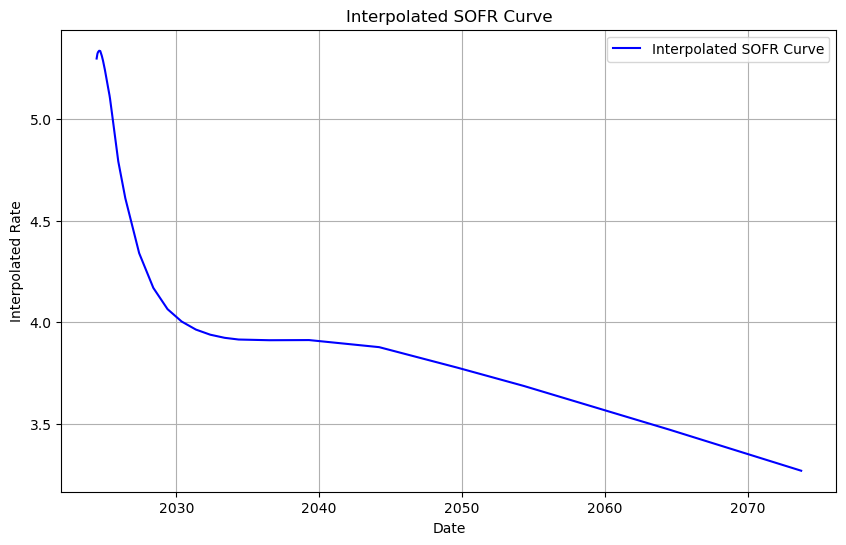

In [6]:
import matplotlib.pyplot as plt

# Extract dates and rates from the DataFrame
dates = all_dates_df['Date']
rates = all_dates_df['Interpolated Rate']

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(dates, rates, label='Interpolated SOFR Curve', color='blue')
plt.xlabel('Date')
plt.ylabel('Interpolated Rate')
plt.title('Interpolated SOFR Curve')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
def NPV_Discounting_Function(cashflows, curve, reference_date, DCC):
    npv = 0.0
    for cf_date, amount in cashflows:
        index = (cf_date - reference_date).days
        discount_rate = curve(cf_date) / 100
        pv = amount / (1 + discount_rate)**(index / 360)  # Assuming ACT/360 for simplicity
        print("Amount: {} discount_rate: {} Index: {} ".format(amount, discount_rate,index))
        npv += pv
        print("npv : {} ".format(npv))

    return npv

In [8]:
# Example data
cashflows = [
    (datetime(2025, 5, 15), 1000),
    (datetime(2026, 5, 15), 1000),
    (datetime(2027, 5, 15), 1000)
]

# Calculate NPV
npv = NPV_Discounting_Function(cashflows, sofr_curve, reference_date, DCC)
print("NPV of cashflows: {:.2f}".format(npv))

Amount: 1000 discount_rate: 0.050976214285714284 Index: 344 
npv : 953.6012171027288 
Amount: 1000 discount_rate: 0.04631810393258427 Index: 709 
npv : 1868.2900078309772 
Amount: 1000 discount_rate: 0.04348405817174515 Index: 1074 
npv : 2749.0359306808423 
NPV of cashflows: 2749.04


In [9]:
# Function to generate cashflows
def Generate_Cashflows(notional, rate_curve, rate_fixing, pay_frequency, start_date, end_date):
    cashflows = []
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    
    if pay_frequency == 'annual':
        freq_days = 360
        periods_per_year = 1
    elif pay_frequency == 'semi-annual':
        freq_days = 180
        periods_per_year = 2
    elif pay_frequency == 'quarterly':
        freq_days = 90
        periods_per_year = 4
    else:
        raise ValueError("Unsupported pay frequency")
    
    # Generate periodic cashflows
    num_periods = int((end_date - start_date).days / freq_days)
    for i in range(1, num_periods + 1):
        cf_date = start_date + timedelta(days=i * freq_days)
        cashflow_amount = notional * rate_fixing / periods_per_year
        cashflows.append((cf_date, cashflow_amount))
    
    # Include the notional amount as the final cashflow at maturity
    cashflows.append((end_date, notional))
    
    return cashflows

In [10]:
# Function to generate present values
def Generate_PVs(cashflows, discount_curve, reference_date):
    pvs = []
    for cf_date, amount in cashflows:
        index = (cf_date - reference_date).days
        discount_rate = discount_curve(cf_date)/100
        pv = amount / (1 + discount_rate)**(index / 360)  # Assuming ACT/360 for simplicity
        pvs.append(pv)
    return pvs

# Function to generate PV01s
def Generate_PV01s(cashflows, discount_curve, reference_date):
    bumped_curve = lambda date: discount_curve(date) + 0.01  # 1 basis point bump
    pv01s = Generate_PVs(cashflows, bumped_curve, reference_date)
    return pv01s

# Function to generate DV01s
def Generate_DV01s(PV_array, PV01_array):
    dv01s = np.array(PV_array) - np.array(PV01_array)
    return dv01s


In [11]:
# Example data
notional = 1000000
rate_fixing = 0.05  # 5% rate fixing
pay_frequency = 'semi-annual'
start_date = '2024-06-05'
end_date = '2034-06-05'

In [12]:
# Generate cashflows
cashflows = Generate_Cashflows(notional, sofr_curve, rate_fixing, pay_frequency, start_date, end_date)

reference_date = datetime.strptime('2024-06-05', '%Y-%m-%d')

# Generate PVs
pvs = Generate_PVs(cashflows, sofr_curve, reference_date)

# Generate PV01s
pv01s = Generate_PV01s(cashflows, sofr_curve, reference_date)

# Generate DV01s
dv01s = Generate_DV01s(pvs, pv01s)

# Output results
cashflows_df = pd.DataFrame(cashflows, columns=['Date', 'Cashflow'])
pvs_df = pd.DataFrame(pvs, columns=['PV'])
pv01s_df = pd.DataFrame(pv01s, columns=['PV01'])
dv01s_df = pd.DataFrame(dv01s, columns=['DV01'])

final_df = pd.concat([cashflows_df, pvs_df, pv01s_df, dv01s_df], axis=1)
print(final_df)

final_df.to_excel('final_df.xlsx', index=False)


         Date   Cashflow             PV           PV01        DV01
0  2024-12-02    25000.0   24365.966756   24364.809552    1.157204
1  2025-05-31    25000.0   23792.362556   23790.098466    2.264091
2  2025-11-27    25000.0   23300.016587   23296.682273    3.334314
3  2026-05-26    25000.0   22840.522241   22836.156512    4.365729
4  2026-11-22    25000.0   22404.598450   22399.238468    5.359982
5  2027-05-21    25000.0   22005.945748   21999.620007    6.325741
6  2027-11-17    25000.0   21605.640522   21598.388903    7.251618
7  2028-05-15    25000.0   21229.559431   21221.409630    8.149801
8  2028-11-11    25000.0   20847.554271   20838.546383    9.007887
9  2029-05-10    25000.0   20482.448214   20472.610027    9.838187
10 2029-11-06    25000.0   20111.400179   20100.771288   10.628891
11 2030-05-05    25000.0   19752.459462   19741.068165   11.391296
12 2030-11-01    25000.0   19392.648027   19380.530216   12.117811
13 2031-04-30    25000.0   19042.900525   19030.083791   12.81

In [13]:
reference_date_str='2024-05-29'
zero_rate_data=pd.read_excel('Zero_Rates_Vanilla.xlsx')
zero_rate_data['Rate']=zero_rate_data['Zero Rate']
zero_rate_results= DCC_Handler(zero_rate_data, holidays, reference_date_str)
zero_rate_curve = Curve_Constructor(zero_rate_results, interp_method, bootstrap, DCC,reference_date_str)
print(zero_rate_results)
date_to_query = pd.to_datetime('2024-06-10')
rate_at_date = zero_rate_curve(date_to_query)
print("Rate at {}: {}".format(date_to_query.strftime('%Y-%m-%d'), rate_at_date))

# Shock the curve
tenors = zero_rate_results['Tenor']
names = tenors  # Assuming names are same as tenors for simplicity
rates = zero_rate_results['Rate'].tolist()
basis_points = [10] * len(tenors)  # Example: shock each point by 1 basis points

#Shock up
flag = 'up'  # Shocking up
shocked_up_rates_ZeroCurve = Curve_Shock_Handler(rates, tenors, names, flag, basis_points)

# Create a new result DataFrame with shocked rates
shocked_result = zero_rate_results.copy()
shocked_result['Rate'] = shocked_up_rates_ZeroCurve

# Construct the shocked  curve
shocked_up_ZeroCurve = Curve_Constructor(shocked_result, interp_method, bootstrap, DCC,reference_date_str)

#Shock down
flag = 'down'  # Shocking up
shocked_dowm_rates_ZeroCurve = Curve_Shock_Handler(rates, tenors, names, flag, basis_points)

# Create a new result DataFrame with shocked rates
shocked_result = zero_rate_results.copy()
shocked_result['Rate'] = shocked_dowm_rates_ZeroCurve

# Construct the shocked  curve
shocked_down_ZeroCurve = Curve_Constructor(shocked_result, interp_method, bootstrap, DCC,reference_date_str)

# Example usage of the shocked curve
date_to_query = pd.to_datetime('2024-06-10')
rate_at_date = shocked_up_ZeroCurve(date_to_query)
print("Shocked up Rate at {}: {}".format(date_to_query.strftime('%Y-%m-%d'), rate_at_date))
rate_at_date = shocked_down_ZeroCurve(date_to_query)
print("Shocked down Rate at {}: {}".format(date_to_query.strftime('%Y-%m-%d'), rate_at_date))



    Tenor        Date  Index Position     Rate
0    1 WK  2024-06-05               7  5.38533
1    2 WK  2024-06-12              14  5.38573
2    3 WK  2024-06-20              22  5.38875
3    1 MO  2024-06-28              30  5.38939
4    2 MO  2024-07-29              61  5.39259
5    3 MO  2024-08-27              90  5.38203
6    4 MO  2024-09-26             120  5.36853
7    5 MO  2024-10-28             152  5.34745
8    6 MO  2024-11-25             180  5.32858
9    7 MO  2024-12-26             211  5.30375
10   8 MO  2025-01-24             240  5.27740
11   9 MO  2025-02-24             271  5.25109
12  10 MO  2025-03-25             300  5.22373
13  11 MO  2025-04-24             330  5.19606
14  12 MO  2025-05-27             363  5.16627
15  18 MO  2025-11-20             540  4.98637
16   2 YR  2026-05-19             720  4.82028
17   3 YR  2027-05-14            1080  4.58060
18   4 YR  2028-05-08            1440  4.42772
19   5 YR  2029-05-03            1800  4.33324
20   6 YR  20

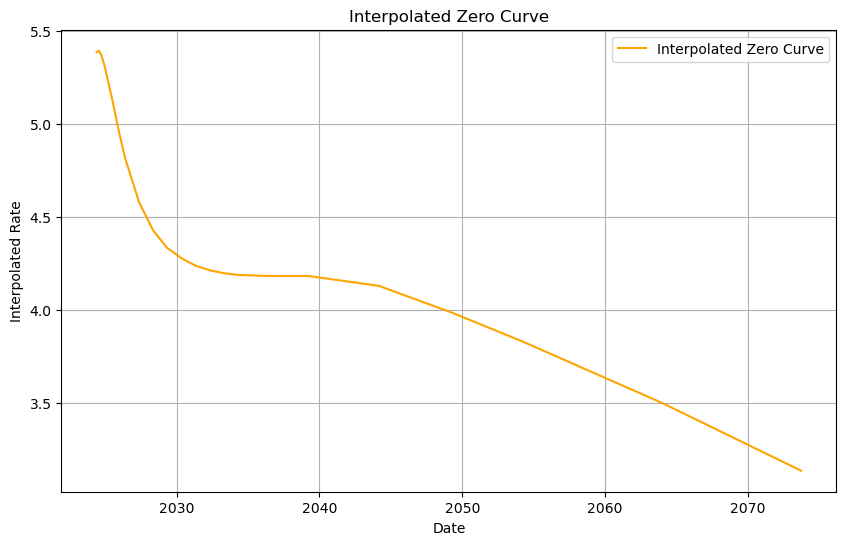

In [14]:
# Generate a DataFrame for all dates and rates (without holidays and weekends)
reference_date = datetime.strptime('2024-05-29', '%Y-%m-%d')
end_date = pd.to_datetime(result['Date']).max()
all_dates = pd.date_range(start=reference_date, end=end_date, freq='D')
all_dates = all_dates[~all_dates.strftime('%Y-%m-%d').isin(holidays)]
all_dates = all_dates[~all_dates.to_series().dt.dayofweek.isin([5, 6])]

interpolated_zero_rates = [zero_rate_curve(date) for date in all_dates]
all_dates_df = pd.DataFrame({
    'Date': all_dates,
    'Interpolated Zero Rate': interpolated_zero_rates    
})
# Extract dates and rates from the DataFrame
dates = all_dates_df['Date']
rates = all_dates_df['Interpolated Zero Rate']

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(dates, rates, label='Interpolated Zero Curve', color='orange')
plt.xlabel('Date')
plt.ylabel('Interpolated Rate')
plt.title('Interpolated Zero Curve')
plt.grid(True)
plt.legend()
plt.show()

In [15]:
def calculate_discount_factors(zero_rate_curve, dates, reference_date):
    discount_factors = []
    for date in dates:
        days = (date - reference_date).days
        rate = zero_rate_curve(date)/100
        df = np.exp(-rate * days / 360)
        discount_factors.append(df)
    return discount_factors

discount_factors = calculate_discount_factors(zero_rate_curve, all_dates, reference_date)
all_dates_df['Discount Factor'] = discount_factors
print(all_dates_df)

            Date Interpolated Zero Rate  Discount Factor
0     2024-05-29                5.38493         1.000000
1     2024-05-30      5.384987142857143         0.999850
2     2024-05-31      5.385044285714286         0.999701
3     2024-06-03      5.385215714285714         0.999252
4     2024-06-04      5.385272857142857         0.999103
...          ...                    ...              ...
12741 2073-09-12     3.1362075402554135         0.208386
12742 2073-09-13      3.136105080510827         0.208378
12743 2073-09-14      3.136002620766241         0.208371
12744 2073-09-15     3.1359001610216546         0.208363
12745 2073-09-18     3.1355927817878957         0.208341

[12746 rows x 3 columns]


In [16]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd

def adjust_for_weekend_and_holiday(date, holidays):
    while date.weekday() >= 5 or date.strftime('%Y-%m-%d') in holidays:
        date += timedelta(days=1)
    return date

def Cashflow_Schedule(start_date, end_date, payment_frequency, holidays):
    cashflow_dates = []
    
    # Convert start and end dates to datetime objects
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    
    # Determine the frequency in months
    if payment_frequency == 'annual':
        freq_months = 12
    elif payment_frequency == 'semi-annual':
        freq_months = 6
    elif payment_frequency == 'quarterly':
        freq_months = 3
    else:
        raise ValueError("Unsupported payment frequency")

    # Calculate the first cashflow date
    first_cashflow_date = start_date + relativedelta(months=freq_months)
    first_cashflow_date = adjust_for_weekend_and_holiday(first_cashflow_date, holidays)
    
    # Generate cashflow dates
    current_date = first_cashflow_date
    while current_date < end_date:
        cashflow_dates.append(current_date)
        current_date += relativedelta(months=freq_months)
        current_date = adjust_for_weekend_and_holiday(current_date, holidays)
    
    # Include end_date if it falls on a valid business day
    if end_date.weekday() < 5 and end_date.strftime('%Y-%m-%d') not in holidays:
        cashflow_dates.append(end_date)
    
    return cashflow_dates

# Provided holidays
holidays = [
    '2024-01-01', '2024-01-15', '2024-02-19', '2024-03-29', '2024-05-27', 
    '2024-06-19', '2024-07-04', '2024-09-02', '2024-11-28', '2024-12-25',
    '2025-01-01', '2025-01-20', '2025-02-17', '2025-04-18', '2025-05-26',
    '2025-06-19', '2025-07-04', '2025-09-01', '2025-10-13', '2025-11-11',
    '2025-11-27', '2025-12-25'
]

# Example usage
start_date = '2024-05-30'
end_date = '2025-05-30'
payment_frequency = 'quarterly'

cashflow_dates = Cashflow_Schedule(start_date, end_date, payment_frequency, holidays)
cashflow_dates_df = pd.DataFrame(cashflow_dates, columns=['Date'])
print(cashflow_dates_df)


        Date
0 2024-08-30
1 2024-12-02
2 2025-03-03
3 2025-05-30


In [17]:
def Cashflow_Generator(start_date,cashflow_dates, reset_frequency, pricing_curve, notional):
    cashflows = []
    previous_date = start_date

    for cf_date in cashflow_dates:
        days_between = (cf_date - previous_date).days
        rate = pricing_curve(cf_date) / 100  # Assuming the pricing curve returns the rate in percentage
        cashflow_amount = notional * rate * (days_between / 360)  # Assuming ACT/360 DCC
        #print("SOFR_RATE: {}".format(rate))
        cashflows.append((cf_date, cashflow_amount))
        previous_date = cf_date
    # Add the notional repayment on the last date
    cashflows[-1] = (cashflows[-1][0], cashflows[-1][1] + notional)
    return cashflows

# Example usage
# Assuming pricing_curve is already defined and implemented
notional = 10000000
reset_frequency = 'quarterly'
start_date= '2024-05-30'

# Assuming sofr_curve is already defined
cashflows = Cashflow_Generator( pd.to_datetime(start_date),cashflow_dates, reset_frequency, sofr_curve, notional)
cashflows_df = pd.DataFrame(cashflows, columns=['Date', 'Cashflow'])
print(cashflows_df)



        Date      Cashflow
0 2024-08-30  1.363430e+05
1 2024-12-02  1.376568e+05
2 2025-03-03  1.309324e+05
3 2025-05-30  1.012411e+07


In [18]:
def Cashflow_Generator_FixedLeg(start_date,cashflow_dates, reset_frequency,fixed_rate,notional):
    cashflows = []
    previous_date= start_date
    for cf_date in cashflow_dates:
        days_between = (cf_date - previous_date).days
        #print("days_between: {}".format(days_between))
        rate = fixed_rate
        cashflow_amount = notional * rate * (days_between / 360)  # Assuming ACT/360 DCC
        cashflows.append((cf_date, cashflow_amount))
        previous_date=cf_date
    # Add the notional repayment on the last date
    #cashflows[-1] = (cashflows[-1][0], cashflows[-1][1] + notional)
    return cashflows

# Example usage
# Assuming pricing_curve is already defined and implemented
notional = 10000000
start_date= '2024-05-30'
fixed_rate= 0.05335167241379311

# Assuming sofr_curve is already defined
cashflows = Cashflow_Generator_FixedLeg(pd.to_datetime(start_date),cashflow_dates, reset_frequency, fixed_rate, notional)
cashflows_df = pd.DataFrame(cashflows, columns=['Date', 'Cashflow'])
print(cashflows_df)



        Date       Cashflow
0 2024-08-30  136343.162835
1 2024-12-02  139307.144636
2 2025-03-03  134861.171935
3 2025-05-30  130415.199234


In [19]:
reference_date_str='2024-05-30'
euro_rate_data=pd.read_excel('euribor_data.xlsx',engine='openpyxl')
euro_rate_data['Term']=euro_rate_data['Tenor']
euro_rate_data['Rate']=euro_rate_data['Yield']
euro_rate_results= DCC_Handler(euro_rate_data, holidays, reference_date_str)
euro_rate_curve = Curve_Constructor(euro_rate_results, interp_method, bootstrap, DCC,reference_date_str)
print(euro_rate_results)
date_to_query = pd.to_datetime('2024-06-10')
rate_at_date = euro_rate_curve(date_to_query)
print("Rate at {}: {}".format(date_to_query.strftime('%Y-%m-%d'), rate_at_date))

   Tenor        Date  Index Position     Rate
0     1M  2024-07-01              32  3.71700
1     2M  2024-07-29              60  3.68935
2     3M  2024-08-28              90  3.68375
3     4M  2024-09-27             120  3.66000
4     5M  2024-10-28             151  3.63600
5     6M  2024-11-26             180  3.61800
6     7M  2024-12-26             210  3.59600
7     8M  2025-01-27             242  3.57600
8     9M  2025-02-24             270  3.55700
9    10M  2025-03-26             300  3.53500
10   11M  2025-04-25             330  3.51400
11    1Y  2025-05-27             362  3.50000
12   15M  2025-08-25             452  3.39000
13   18M  2025-11-21             540  3.39000
14   21M  2026-02-19             630  3.28000
15    2Y  2026-05-20             720  3.23040
16    3Y  2027-05-17            1082  3.08600
17    4Y  2028-05-09            1440  2.96400
18    5Y  2029-05-04            1800  2.89100
19    6Y  2030-04-29            2160  2.84000
20    7Y  2031-04-24            25

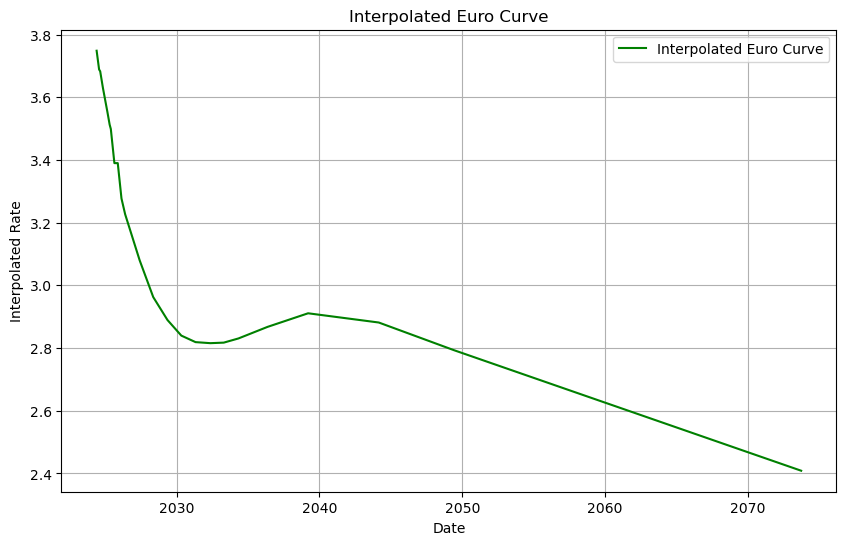

In [20]:
# Generate a DataFrame for all dates and rates (without holidays and weekends)
reference_date = datetime.strptime('2024-05-30', '%Y-%m-%d')
end_date = pd.to_datetime(result['Date']).max()
all_dates = pd.date_range(start=reference_date, end=end_date, freq='D')
all_dates = all_dates[~all_dates.strftime('%Y-%m-%d').isin(holidays)]
all_dates = all_dates[~all_dates.to_series().dt.dayofweek.isin([5, 6])]

interpolated_euro_rates = [euro_rate_curve(date) for date in all_dates]
all_dates_df = pd.DataFrame({
    'Date': all_dates,
    'Interpolated Euro Rate': interpolated_euro_rates    
})
# Extract dates and rates from the DataFrame
dates = all_dates_df['Date']
rates = all_dates_df['Interpolated Euro Rate']

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(dates, rates, label='Interpolated Euro Curve', color='green')
plt.xlabel('Date')
plt.ylabel('Interpolated Rate')
plt.title('Interpolated Euro Curve')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
reference_date_str='2024-05-30'
basis_rate_data=pd.read_excel('basis_data.xlsx',engine='openpyxl')
basis_rate_data['Term']=basis_rate_data['Tenor']
basis_rate_data['Rate']=basis_rate_data['Spread']
basis_rate_results= DCC_Handler(basis_rate_data, holidays, reference_date_str)
basis_rate_curve = Curve_Constructor(basis_rate_results, interp_method, bootstrap, DCC,reference_date_str)
print(basis_rate_results)
date_to_query = pd.to_datetime('2024-06-10')
rate_at_date = basis_rate_curve(date_to_query)
print("Rate at {}: {}".format(date_to_query.strftime('%Y-%m-%d'), rate_at_date))

   Tenor        Date  Index Position      Rate
0     1W  2024-06-06               7   2.71028
1     2W  2024-06-13              14   2.14706
2     1M  2024-07-01              32  -0.17597
3     2M  2024-07-29              60  -1.02999
4     3M  2024-08-28              90  -2.01672
5     4M  2024-09-27             120  -3.07915
6     5M  2024-10-28             151  -3.49950
7     6M  2024-11-26             180  -3.85262
8     9M  2025-02-24             270  -8.52573
9    12M  2025-05-27             362  -8.71016
10    2Y  2026-05-20             720  -7.12500
11    3Y  2027-05-17            1082  -8.12500
12    4Y  2028-05-09            1440  -9.12500
13    5Y  2029-05-04            1800 -10.12500
14    6Y  2030-04-29            2160 -11.00000
15    7Y  2031-04-24            2520 -11.87500
16    8Y  2032-04-19            2881 -12.50000
17    9Y  2033-04-13            3240 -13.00000
18   10Y  2034-04-10            3602 -13.50000
19   12Y  2036-03-28            4320 -14.75000
20   15Y  203

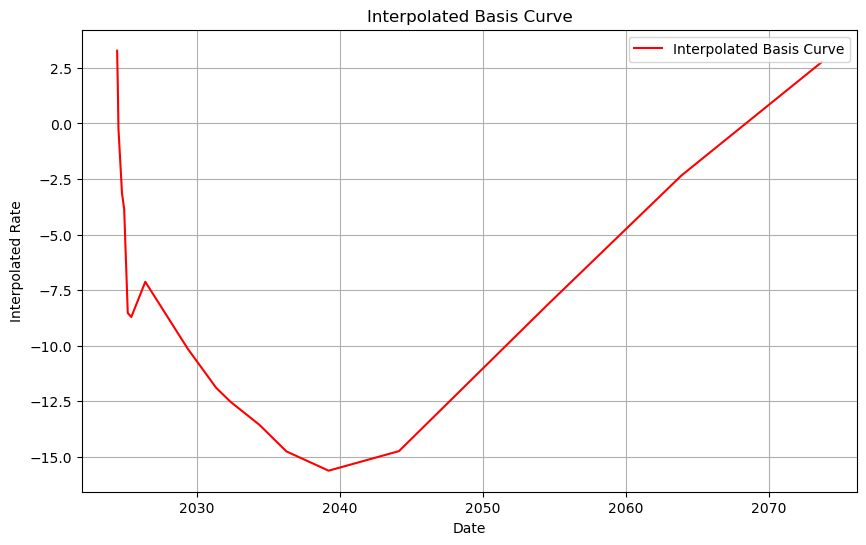

In [22]:
# Generate a DataFrame for all dates and rates (without holidays and weekends)
reference_date = datetime.strptime('2024-05-30', '%Y-%m-%d')
end_date = pd.to_datetime(result['Date']).max()
all_dates = pd.date_range(start=reference_date, end=end_date, freq='D')
all_dates = all_dates[~all_dates.strftime('%Y-%m-%d').isin(holidays)]
all_dates = all_dates[~all_dates.to_series().dt.dayofweek.isin([5, 6])]

interpolated_basis_rates = [basis_rate_curve(date) for date in all_dates]
all_dates_df = pd.DataFrame({
    'Date': all_dates,
    'Interpolated Basis Rate': interpolated_basis_rates    
})
# Extract dates and rates from the DataFrame
dates = all_dates_df['Date']
rates = all_dates_df['Interpolated Basis Rate']

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(dates, rates, label='Interpolated Basis Curve', color='red')
plt.xlabel('Date')
plt.ylabel('Interpolated Rate')
plt.title('Interpolated Basis Curve')
plt.grid(True)
plt.legend()
plt.show()

In [23]:

# Function to generate a series of business days between two dates
def generate_business_days(start_date, end_date, holidays):
    # Generate a date range with business days (excluding weekends)
    business_days = pd.date_range(start_date, end_date, freq='B').tolist()
    # Convert holidays to datetime objects
    holidays = pd.to_datetime(holidays).tolist()
    # Exclude holidays from the business days
    business_days = [day for day in business_days if day not in holidays]
    return business_days

# Function to calculate the effective rate
def calculate_effective_rate(daily_rate, days_in_period):
    return ((1 + daily_rate / 100) ** (days_in_period / 360) - 1) * 100

# Function to compound rates
def calculate_compounded_rate(daily_rates, start_date, end_date, holidays):
    business_days = generate_business_days(start_date, end_date, holidays)
    compounded_rate = 1.0
    for day in business_days:
        daily_rate = daily_rates.get(day, 0) / 100  # daily rate in decimal
        compounded_rate *= (1 + daily_rate / 360)
    compounded_rate = (compounded_rate - 1) * 360 / len(business_days) * 100
    return compounded_rate

# Function to generate daily rates from the SOFR curve
def generate_daily_rates(sofr_curve, start_date, end_date, holidays):
    business_days = generate_business_days(start_date, end_date, holidays)
    daily_rates = {}
    for day in business_days:
        daily_rates[day] = sofr_curve(day)
    return daily_rates

# Function to calculate cashflow amounts using compounded rates
def Cashflow_Generator_SOFRCashflows(start_date, cashflow_dates, sofr_curve, notional, holidays):
    cashflows = []
    daily_rates = generate_daily_rates(sofr_curve, start_date, cashflow_dates[-1], holidays)
    previous_date = start_date

    for i, cf_date in enumerate(cashflow_dates):
        days_in_period = (cf_date - previous_date).days
        compounded_rate = calculate_compounded_rate(daily_rates, previous_date, cf_date, holidays)
        cashflow_amount = notional * compounded_rate / 100 * (days_in_period/360)
        print(compounded_rate)
        cashflows.append((cf_date, cashflow_amount))
        previous_date = cf_date

    return cashflows


In [24]:
# Example usage Fixed vs Floating Swap
reference_date_str = '2024-05-30'

# Fixed leg parameters
fixed_start_date = '2024-05-30'
fixed_end_date = '2025-05-30'
fixed_notional = 10000000
fixed_rate = 0.05335  # 

# Floating leg parameters
float_start_date = '2024-05-30'
float_end_date = '2025-05-30'
float_notional = 10000000

# Generate cashflow schedules
fixed_cashflow_dates = Cashflow_Schedule(fixed_start_date, fixed_end_date, 'quarterly', holidays)
float_cashflow_dates = Cashflow_Schedule(float_start_date, float_end_date, 'quarterly', holidays)


# Generate floating leg cashflows using SOFR compounded rates
float_cashflows = Cashflow_Generator_SOFRCashflows(pd.to_datetime(float_start_date), float_cashflow_dates, sofr_curve, float_notional, holidays)

# Print the cashflows
print(pd.DataFrame(float_cashflows, columns=['Date', 'Cashflow']))






5.3501827767398975
5.333627444685973
5.250732306598943
5.153747138136084
        Date       Cashflow
0 2024-08-30  136726.893183
1 2024-12-02  139266.938833
2 2025-03-03  132726.844417
3 2025-05-30  125980.485599


In [26]:
# Example usage Fixed vs Floating Swap
reference_date_str = '2024-06-07'

# Fixed leg parameters
fixed_start_date = '2024-06-07'
fixed_end_date = '2025-06-09'
fixed_notional = 10000000
fixed_rate = 0.05335

# Floating leg parameters
float_start_date = '2024-06-07'
float_end_date = '2025-06-09'
float_notional = 10000000

# Generate cashflow schedules
fixed_cashflow_dates = Cashflow_Schedule(fixed_start_date, fixed_end_date, 'quarterly', holidays)
float_cashflow_dates = Cashflow_Schedule(float_start_date, float_end_date, 'quarterly', holidays)


# Generate cashflows
fixed_cashflows = Cashflow_Generator_FixedLeg(pd.to_datetime(fixed_start_date),float_cashflow_dates, 'quarterly', fixed_rate, fixed_notional)
float_cashflows = Cashflow_Generator_SOFRCashflows(pd.to_datetime(float_start_date), float_cashflow_dates, sofr_curve, float_notional, holidays)

print(pd.DataFrame(fixed_cashflows,columns=['Date','Cashflow']))
print(pd.DataFrame(float_cashflows,columns=['Date','Cashflow']))


# Calculate discount factors
all_dates = sorted(set(fixed_cashflow_dates + float_cashflow_dates))
discount_factors = calculate_discount_factors(zero_rate_curve, all_dates, datetime.strptime(reference_date_str, '%Y-%m-%d'))
discount_factors_shockedup10= calculate_discount_factors(shocked_up_ZeroCurve, all_dates, datetime.strptime(reference_date_str, '%Y-%m-%d'))
#discount_factors_shockeddown10=calculate_discount_factors(shocked_down_ZeroCurve, all_dates, datetime.strptime(reference_date_str, '%Y-%m-%d'))

print(pd.DataFrame(discount_factors,columns=['Discount_Factor']))

# Calculate present values for the fixed leg
fixed_pvs = [fixed_cashflow[1] * discount_factors[i] for i, fixed_cashflow in enumerate(fixed_cashflows)]

# Calculate present values for the floating leg
float_pvs = [float_cashflow[1] * discount_factors[i] for i, float_cashflow in enumerate(float_cashflows)]

# Calculate net present value
fixed_leg_pv = sum(fixed_pvs)
print("fixed_leg_pv:{}".format(fixed_leg_pv))
float_leg_pv = sum(float_pvs)
print("float_leg_pv:{}".format(float_leg_pv))

npv = float_leg_pv - fixed_leg_pv
print("npv:{}".format(npv))

# #Calculations of PV Shifted
fixed_cashflows_shifted_up = Cashflow_Generator_FixedLeg(pd.to_datetime(fixed_start_date),float_cashflow_dates, 'quarterly', (fixed_rate+0.0001), fixed_notional)
fixed_cashflows_shifted_down = Cashflow_Generator_FixedLeg(pd.to_datetime(fixed_start_date),float_cashflow_dates, 'quarterly', (fixed_rate-0.0001), fixed_notional)

# float_cashflows_shifted = Cashflow_Generator(pd.to_datetime(float_start_date),float_cashflow_dates, 'quarterly', shocked_curve, float_notional)
fixed_pvs_shifted_up = [fixed_cashflow[1] * discount_factors[i] for i, fixed_cashflow in enumerate(fixed_cashflows_shifted_up)]
fixed_pvs_shifted_down = [fixed_cashflow[1] * discount_factors[i] for i, fixed_cashflow in enumerate(fixed_cashflows_shifted_down)]

#  Calculate net present value for shifted fixed cashflows
PV_fixed_shifted_up = sum(fixed_pvs_shifted_up)
PV_fixed_shifted_down= sum(fixed_pvs_shifted_down)

npv_shifted_up = float_leg_pv-PV_fixed_shifted_up
npv_shifted_down = float_leg_pv-PV_fixed_shifted_down

#  Calculate DV01
DV01=(npv_shifted_up-npv_shifted_down)/2
print("DV01: {}".format(DV01))


#Curveshock sofr rates by 10bps
float_cashflows_shifted_up10= Cashflow_Generator_SOFRCashflows(pd.to_datetime(float_start_date), float_cashflow_dates, shocked_curve_sofr, float_notional, holidays)
float_pvs_shifted_up10 = [float_cashflow[1] * discount_factors_shockedup10[i] for i, float_cashflow in enumerate(float_cashflows_shifted_up10)]


reference_date = datetime.strptime(reference_date_str, '%Y-%m-%d')
# Prepare final DataFrame
data = []
#data.append([reference_date.strftime('%d/%m/%Y'), fixed_notional , fixed_notional, 0])
for i in range(len(all_dates)):
    pay_date = all_dates[i]
    fixed_cf = fixed_cashflows[i][1] if i < len(fixed_cashflows) else 0
    float_cf = float_cashflows[i][1] if i < len(float_cashflows) else 0
    net_payment = float_cf - fixed_cf
    discount = discount_factors[i]
    zero_rate = zero_rate_curve((pd.to_datetime(pay_date)- pd.to_datetime(reference_date_str)).days) / 100
    #pv = fixed_pvs[i] if i < len(fixed_pvs) else 0 - float_pvs[i] if i < len(float_pvs) else 0
    data.append([pay_date.strftime('%d/%m/%Y'), fixed_cf, float_cf, net_payment, discount, zero_rate])

result_df = pd.DataFrame(data, columns=['Pay Date', 'Payments(Rcv)', 'Payments(Pay)', 'Net Payments', 'Discount', 'Zero Rate'])
print(result_df)

result_df.to_excel('swap_cashflows.xlsx', index=False)

5.353402851040273
5.328496915083337
5.243067281447963
5.144559538483348
        Date       Cashflow
0 2024-09-09  139302.777778
1 2024-12-09  134856.944444
2 2025-03-10  134856.944444
3 2025-06-09  134856.944444
        Date       Cashflow
0 2024-09-09  139783.296666
1 2024-12-09  134692.560909
2 2025-03-10  132533.089614
3 2025-06-09  130043.032778
   Discount_Factor
0         0.986060
1         0.973045
2         0.960639
3         0.948823
fixed_leg_pv:526086.960676614
float_leg_pv:519600.89209494414
npv:-6486.068581669824
DV01: -986.104893489508
5.454348458272945
5.429453105833463
5.3439641722943385
5.2454686002934565
     Pay Date  Payments(Rcv)  Payments(Pay)  Net Payments  Discount  Zero Rate
0  09/09/2024  139302.777778  139783.296666    480.518888  0.986060   0.053802
1  09/12/2024  134856.944444  134692.560909   -164.383535  0.973045   0.053246
2  10/03/2025  134856.944444  132533.089614  -2323.854830  0.960639   0.052464
3  09/06/2025  134856.944444  130043.032778  -4813.911